## Classifications of Euro Coins with Siamese Network (with data augmentation)

In [1]:
# load data from google drive
!unzip /content/drive/MyDrive/data_eurocoins.zip

Streaming output truncated to the last 5000 lines.
  inflating: Data/euro_coins/20c/IMG_20190707_130535_5.jpg  
  inflating: Data/euro_coins/20c/IMG_20190707_130535_6.jpg  
  inflating: Data/euro_coins/20c/IMG_20190707_130535_7.jpg  
  inflating: Data/euro_coins/20c/IMG_20190707_130535_8.jpg  
  inflating: Data/euro_coins/20c/IMG_20190707_130535_9.jpg  
  inflating: Data/euro_coins/20c/IMG_20190707_130537_0.jpg  
  inflating: Data/euro_coins/20c/IMG_20190707_130537_1.jpg  
  inflating: Data/euro_coins/20c/IMG_20190707_130537_3.jpg  
  inflating: Data/euro_coins/20c/IMG_20190707_130537_4.jpg  
  inflating: Data/euro_coins/20c/IMG_20190707_130537_5.jpg  
  inflating: Data/euro_coins/20c/IMG_20190707_130537_6.jpg  
  inflating: Data/euro_coins/20c/IMG_20190707_130537_7.jpg  
  inflating: Data/euro_coins/20c/IMG_20190707_130537_8.jpg  
  inflating: Data/euro_coins/20c/IMG_20190707_130537_9.jpg  
  inflating: Data/euro_coins/20c/IMG_20190707_130546_0.jpg  
  inflating: Data/euro_coins/20c/I

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import random

import keras
import numpy as np
import os
import PIL
import PIL.Image
import pathlib
import matplotlib.pyplot as plt

from keras import backend as K




from keras.applications import resnet50


import tensorflow.keras.layers as Layers
import tensorflow.keras.activations as Actications
import tensorflow.keras.models as Models
import tensorflow.keras.optimizers as Optimizer
import tensorflow.keras.metrics as Metrics
import tensorflow.keras.utils as Utils
from keras.utils.vis_utils import model_to_dot



import time




In [3]:
batch_size = 32
img_height = 256
img_width =  256

In [4]:
# data generators

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
            rescale=1./255,
            validation_split=0.2)

train_generator = datagen.flow_from_directory(
                    'Data/euro_coins',
                    target_size=(img_height, img_width),
                    batch_size=batch_size,
                    shuffle=True,
                    seed=123,
                    subset='training')


valid_generator = datagen.flow_from_directory(
                    'Data/euro_coins',
                    target_size=(img_height, img_width),
                    batch_size=batch_size,
                    shuffle=True,
                    seed=123,
                    subset='validation')
        





Found 6742 images belonging to 8 classes.
Found 1683 images belonging to 8 classes.


In [5]:
X_train=[]
y_train=[]

train_generator.reset()

for i in range(train_generator.__len__()):
   a,b=train_generator.next()
   X_train.extend(a)
   y_train.extend(b)


X_train=np.array(X_train)
y_train=np.array(y_train)

In [6]:
X_valid=[]
y_valid=[]

valid_generator.reset()

for i in range(valid_generator.__len__()):
   a,b=valid_generator.next()
   X_valid.extend(a)
   y_valid.extend(b)


X_valid=np.array(X_valid)
y_valid=np.array(y_valid)


In [7]:
n_classes = len(y_train[0])

In [8]:
y_train = np.array([y_train[i].tolist().index(1) for i in range(len(y_train))])
y_valid = np.array([y_valid[i].tolist().index(1) for i in range(len(y_valid))])

In [9]:
# Data augmentation

data_augmentation = tf.keras.preprocessing.image.ImageDataGenerator(
            rotation_range=90,
            zoom_range=0.5,
            height_shift_range=0.1,
            width_shift_range=0.1)

In [10]:
def get_pairs(batch_size,test=False):

  if test:

    X = X_valid
    y = y_valid
    
  else:

    X = X_train
    y = y_train
   

  n, img_height,img_width, c = X_train.shape

  pairs=[np.zeros((batch_size, img_height, img_width,c)) for i in range(2)]
  targets=np.zeros((batch_size))

  targets[batch_size//2:] = 1




  for i in range(batch_size):

    
    idx1 = np.random.randint(0,n)

    pairs[0][i,:,:,:] = data_augmentation.flow(X[idx1:idx1+1])[0][0] # apply data augmentation


    idx2 = np.random.randint(0,n)


    if i < batch_size//2 :
    
      while y[idx1] == y[idx2]:

        idx2 = np.random.randint(0,n)
    

    if i >= batch_size//2 :
    
      while y[idx1] != y[idx2]:

        idx2 = np.random.randint(0,n)
  

    pairs[1][i,:,:,:] = data_augmentation.flow(X[idx2:idx2+1])[0][0]  # apply data augmentation



  return pairs, targets

In [11]:
def pairs_generator(batch_size, test = False):
    while True:
        pairs, targets = get_pairs(batch_size,test = test)
        yield (pairs, targets)

In [12]:
# Siamese network

input_left = Layers.Input((img_width,img_height,3))
input_right = Layers.Input((img_width,img_height,3))


resnet_model = resnet50.ResNet50(weights='imagenet', include_top=False, input_shape=(img_width,img_height,3))

base_model = tf.keras.Sequential()
base_model.add(resnet_model)
base_model.add(Layers.GlobalAveragePooling2D())

encoded_left = base_model(input_left)
encoded_right = base_model(input_right)



L1_layer = Layers.Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
L1_distance = L1_layer([encoded_left, encoded_right])


prediction = Layers.Dense(1,activation='sigmoid')(L1_distance)

model = tf.keras.models.Model(inputs=[input_left,input_right],outputs=prediction)



model.summary()


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 2048)         23587712    input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 2048)         0           sequential[0][0]      

In [13]:
model.compile(loss="binary_crossentropy",optimizer = keras.optimizers.Adam(learning_rate=1e-4))


In [14]:
batch_size = 16
steps_per_epoch = X_train.shape[0]//batch_size

In [15]:
tic = time.time()

trained = model.fit(
            pairs_generator(batch_size),
            steps_per_epoch=steps_per_epoch,
            epochs=20,
            )

toc=time.time()    
print(str(toc-tic)+ ' s')

Epoch 1/20
421/421 [==============================] - 201s 478ms/step - loss: 0.4083
Epoch 2/20
421/421 [==============================] - 200s 476ms/step - loss: 0.2685
Epoch 3/20
421/421 [==============================] - 198s 471ms/step - loss: 0.1627
Epoch 4/20
421/421 [==============================] - 198s 471ms/step - loss: 0.1231
Epoch 5/20
421/421 [==============================] - 198s 470ms/step - loss: 0.0939
Epoch 6/20
421/421 [==============================] - 199s 473ms/step - loss: 0.0673
Epoch 7/20
421/421 [==============================] - 201s 477ms/step - loss: 0.0448
Epoch 8/20
421/421 [==============================] - 201s 477ms/step - loss: 0.0652
Epoch 9/20
421/421 [==============================] - 198s 470ms/step - loss: 0.0279
Epoch 10/20
421/421 [==============================] - 197s 469ms/step - loss: 0.0312
Epoch 11/20
421/421 [==============================] - 197s 468ms/step - loss: 0.0561
Epoch 12/20
421/421 [==============================] - 197s 468

In [19]:
# save model
t = time.time()

export_path_keras = "./{}.h5".format(int(t))
print(export_path_keras)

model.save(export_path_keras)

./1606417847.h5


In [20]:
!ls

1606417847.h5  Data  drive  sample_data


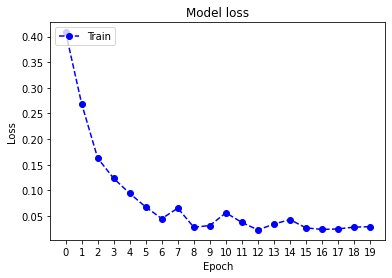

In [16]:
plt.plot(trained.history['loss'],'bo--')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.xticks(np.arange(0,20,1))
plt.show()

In [17]:
def one_shot_task(X_valid1,X_train,y_train):

  pairs=[np.zeros((n_classes, img_height, img_width,3)) for i in range(2)]

  n_samples = len(y_train)

  for i in range(n_classes):

     pairs[0][i,:,:,:] = X_valid1


  for i in range(n_classes):

    idx2 = np.random.randint(0,n_samples)

    while y_train[idx2] != i :
      idx2 = np.random.randint(0,n_samples)
    


    pairs[1][i,:,:,:] = X_train[idx2]

  return pairs

In [25]:
def test_accuracy(X_valid,y_valid,X_train,y_train):

  n_correct = 0
  n_all = len(X_valid)

  for i in range(n_all):

    pred = np.argmax( model.predict(one_shot_task(X_valid[i],X_train,y_train)) )

    if y_valid[i] == pred:

      n_correct+=1

      if i!=0 and i%100 == 0: print('step:', i, 'accuracy:', 100 * n_correct/(i+1))

  accuracy = 100.0 * n_correct / n_all
  print('step:', n_all, 'accuracy:',  accuracy)


  return accuracy



In [21]:
# accuracy on train data set

tic=time.time()

test_accuracy(X_train,y_train,X_train,y_train)

toc=time.time()   
print(str(toc-tic)+ ' s')

step: 100 accuracy: 100.0
step: 200 accuracy: 100.0
step: 300 accuracy: 100.0
step: 400 accuracy: 100.0
step: 500 accuracy: 100.0
step: 600 accuracy: 100.0
step: 700 accuracy: 100.0
step: 800 accuracy: 100.0
step: 900 accuracy: 100.0
step: 1000 accuracy: 100.0
step: 1100 accuracy: 100.0
step: 1200 accuracy: 100.0
step: 1300 accuracy: 100.0
step: 1400 accuracy: 100.0
step: 1500 accuracy: 100.0
step: 1600 accuracy: 100.0
step: 1700 accuracy: 100.0
step: 1800 accuracy: 100.0
step: 1900 accuracy: 100.0
step: 2000 accuracy: 100.0
step: 2100 accuracy: 100.0
step: 2200 accuracy: 100.0
step: 2300 accuracy: 100.0
step: 2400 accuracy: 100.0
step: 2500 accuracy: 100.0
step: 2600 accuracy: 100.0
step: 2700 accuracy: 100.0
step: 2800 accuracy: 100.0
step: 2900 accuracy: 100.0
step: 3000 accuracy: 100.0
step: 3100 accuracy: 100.0
step: 3200 accuracy: 100.0
step: 3300 accuracy: 100.0
step: 3400 accuracy: 100.0
step: 3500 accuracy: 100.0
step: 3600 accuracy: 100.0
step: 3700 accuracy: 100.0
step: 3800

In [22]:
# accuracy on validation data set

tic=time.time()

test_accuracy(X_valid,y_valid,X_train,y_train)

toc=time.time()   
print(str(toc-tic)+ ' s')

step: 100 accuracy: 88.11881188118812
step: 200 accuracy: 91.04477611940298
step: 300 accuracy: 90.69767441860465
step: 400 accuracy: 91.02244389027432
step: 500 accuracy: 91.21756487025948
step: 600 accuracy: 91.51414309484193
step: 700 accuracy: 90.72753209700429
step: 900 accuracy: 91.00998890122086
step: 1000 accuracy: 91.20879120879121
step: 1100 accuracy: 90.82652134423252
step: 1200 accuracy: 90.59117402164863
step: 1300 accuracy: 90.62259800153728
step: 1500 accuracy: 90.67288474350433
step: 1600 accuracy: 90.44347282948158
134.91182255744934 s


In [26]:
def test_accuracy_augment(X_valid,y_valid,X_train,y_train):

  n_correct = 0
  n_all = len(X_valid)

  for i in range(n_all):

    pred = np.argmax( model.predict(one_shot_task(data_augmentation.flow(X_valid[i:i+1])[0][0],X_train,y_train)) )

    if y_valid[i] == pred:

      n_correct+=1

      if i!=0 and i%100 == 0: print('step:', i, 'accuracy:', 100 * n_correct/(i+1))

  accuracy = 100.0 * n_correct / n_all
  print('step:', n_all, 'accuracy:', accuracy)

  return accuracy

In [24]:
# test accuracy applying data augmentation on train dataset
tic=time.time()

test_accuracy_augment(X_train,y_train,X_train,y_train)

toc=time.time()   
print(str(toc-tic)+ ' s')

step: 100 accuracy: 100.0
step: 200 accuracy: 100.0
step: 300 accuracy: 99.66777408637874
step: 400 accuracy: 99.75062344139651
step: 500 accuracy: 99.8003992015968
step: 600 accuracy: 99.83361064891847
step: 700 accuracy: 99.85734664764622
step: 800 accuracy: 99.87515605493134
step: 900 accuracy: 99.88901220865705
step: 1000 accuracy: 99.9000999000999
step: 1100 accuracy: 99.90917347865577
step: 1200 accuracy: 99.83347210657786
step: 1300 accuracy: 99.84627209838585
step: 1400 accuracy: 99.78586723768737
step: 1500 accuracy: 99.80013324450367
step: 1700 accuracy: 99.76484420928865
step: 1800 accuracy: 99.7223764575236
step: 1900 accuracy: 99.7369805365597
step: 2000 accuracy: 99.70014992503748
step: 2100 accuracy: 99.7144217039505
step: 2200 accuracy: 99.72739663789187
step: 2300 accuracy: 99.73924380704042
step: 2400 accuracy: 99.75010412328197
step: 2500 accuracy: 99.76009596161535
step: 2600 accuracy: 99.73087274125336
step: 2700 accuracy: 99.70381340244354
step: 2800 accuracy: 99.

99.68851972708396

In [27]:
# test accuracy applying data augmentation on validation dataset
tic=time.time()

test_accuracy_augment(X_valid,y_valid,X_train,y_train)

toc=time.time()   
print(str(toc-tic)+ ' s')

step: 100 accuracy: 90.0990099009901
step: 200 accuracy: 91.04477611940298
step: 300 accuracy: 91.36212624584718
step: 400 accuracy: 92.26932668329177
step: 500 accuracy: 92.01596806387225
step: 600 accuracy: 91.846921797005
step: 700 accuracy: 91.01283880171184
step: 800 accuracy: 90.6367041198502
step: 900 accuracy: 91.00998890122086
step: 1000 accuracy: 91.008991008991
step: 1100 accuracy: 90.55404178019982
step: 1200 accuracy: 90.50791007493756
step: 1300 accuracy: 90.5457340507302
step: 1500 accuracy: 90.53964023984011
step: 1600 accuracy: 90.44347282948158
step: 1683 accuracy: 90.67142008318478
157.50267553329468 s
